In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import make_time_series, lowpass_2d
import s3fs
import pandas as pd
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

In [2]:
def load_sys(n, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    id = meta['ID'][n]
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(id), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, id)
    return df

In [3]:
df = load_sys(101, local=False)

101 10838


In [4]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2012-08-19 2017-07-30


In [5]:
end - start

Timedelta('1806 days 00:00:00')

In [6]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')

In [7]:
ics = IterativeClearSky(D, k=4)

In [8]:
ics.fixedTimeStamps

False

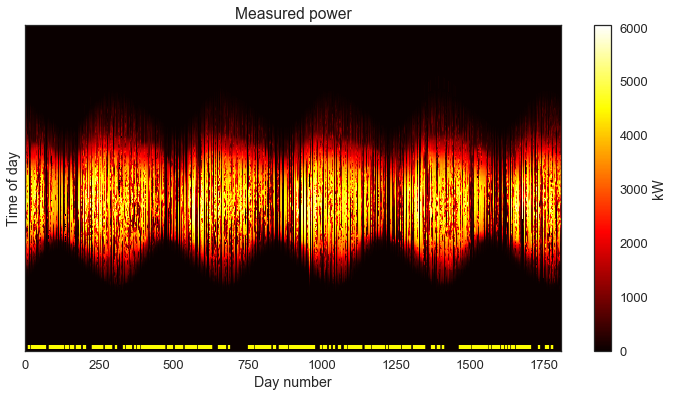

In [8]:
_ = ics.plot_D(show_days=True)

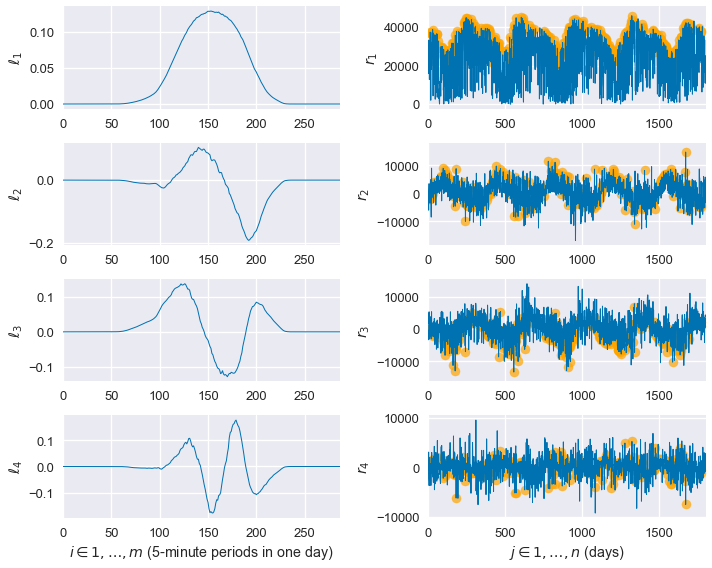

In [9]:
_ = ics.plot_singular_vectors(show_days=True)

In [10]:
ics.mu_L = 1e5
ics.mu_R = 1e3
ics.tau = 0.9
import cvxpy as cvx
try:
    ics.minimize_objective(eps=5e-3, max_iter=10, min_deg=None, max_deg=None)
except cvx.SolverError:
    print('solver failed!')

starting at 1353188155.662 [4181341.7688547233, 10185.011547608054, 1079686621.7197158, 269310007.16198057]
iteration 1: 2838331.624 [2.58763434e+06 2.76235300e+03 2.47934797e+05 1.34000000e-01]
iteration 2: 2344979.036 [2.07764495e+06 5.41655700e+03 2.61917498e+05 2.90000000e-02]
iteration 3: 2303410.501 [2.03876221e+06 5.45327000e+03 2.59194943e+05 8.30000000e-02]
iteration 4: 2292051.619 [2.03120681e+06 5.71768500e+03 2.55127109e+05 1.80000000e-02]
Minimization complete in 3.03 minutes


In [11]:
clearsky = ics.L_cs.value.dot(ics.R_cs.value)
m = clearsky != 0
residuals = np.divide(clearsky[m] - ics.D[m], clearsky[m])
print(np.linalg.norm(residuals))

2120.6443245882588


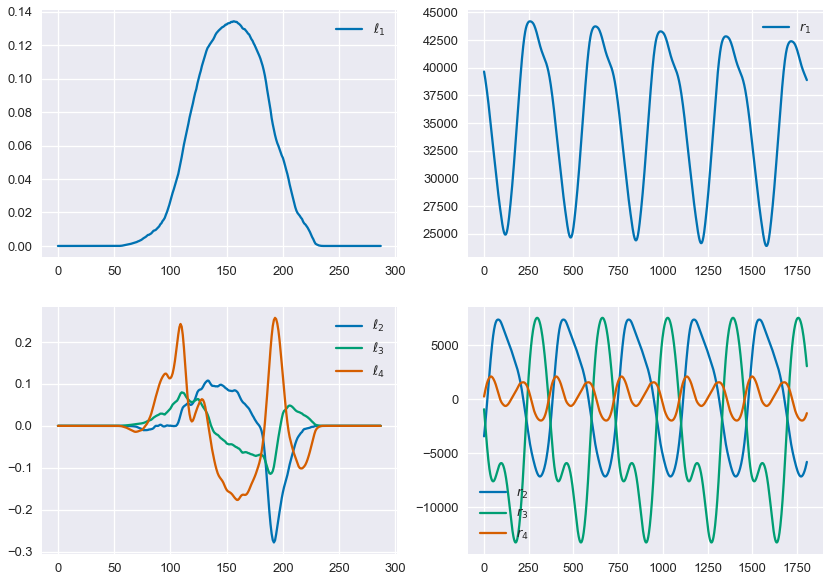

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax[0, 1].plot(ics.R_cs.value[0])
ax[1, 1].plot(ics.R_cs.value[1:].T)
ax[0, 0].plot(ics.L_cs.value[:, 0])
ax[1, 0].plot(ics.L_cs.value[:, 1:])
ax[0, 0].legend(['$\\ell_1$'])
ax[1, 0].legend(['$\\ell_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
ax[0, 1].legend(['$r_{1}$'])
ax[1, 1].legend(['$r_{}$'.format(ix) for ix in range(2, ics.R_cs.value.shape[0]+1)])
plt.show()

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [13]:
ics.beta.value

array(-0.01037598)

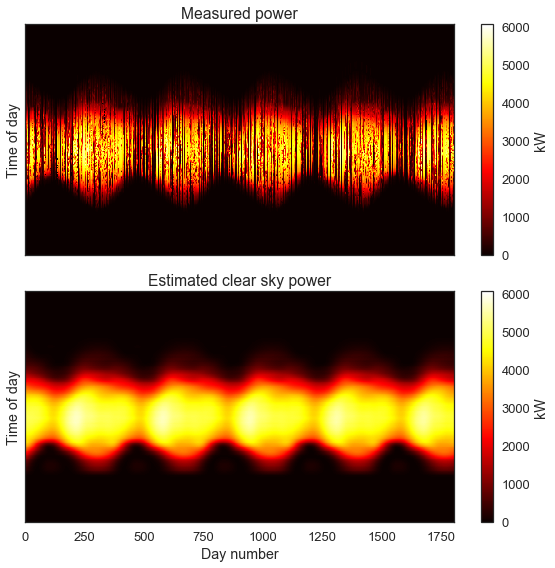

In [14]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=2, figsize=(8,8), sharex=True)
    foo = ax[0].imshow(ics.D, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax[0].set_title('Measured power')
    bar = ax[1].imshow(ics.L_cs.value.dot(ics.R_cs.value), cmap='hot',
                       vmin=0, vmax=np.max(ics.D), interpolation='none', aspect='auto')
    ax[1].set_title('Estimated clear sky power')
    plt.colorbar(foo, ax=ax[0], label='kW')
    plt.colorbar(bar, ax=ax[1], label='kW')
    ax[1].set_xlabel('Day number')
    ax[0].set_yticks([])
    ax[0].set_ylabel('Time of day')
    ax[1].set_yticks([])
    ax[1].set_ylabel('Time of day')
    plt.tight_layout()

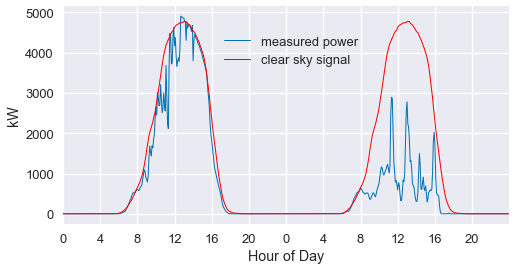

In [15]:
D1 = 1500
D2 = D1 + 2
actual = p[D1*288:D2*288].values
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=1, figsize=(8,4))
ax.plot(actual, linewidth=1, label='measured power')
ax.plot(clearsky, linewidth=1, color='red', label='clear sky signal')
plt.legend(loc=(.35,.7))
ax.set_xlim(0, 288*(D2-D1))
ax.set_ylabel('kW')
ax.set_xticks(np.arange(0, 288*2, 2*24))
ax.set_xticklabels(np.tile(np.arange(0,24,4),2))
ax.set_xlabel('Hour of Day')
plt.show()

In [16]:
print(sum(ics.L_cs.shape) + sum(ics.R_cs.shape))

2102


(0, 1440)

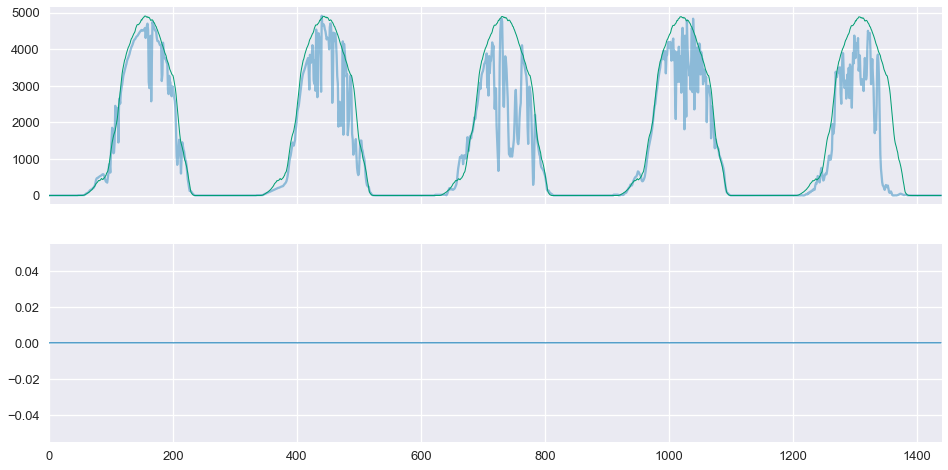

In [17]:
D1 = 1400
D2 = D1+5
actual = p[D1*288:D2*288].values
clearsky = ((ics.L_cs.value.dot(ics.R_cs.value)))[:, D1:D2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(ics.weights[D1:D2], 288), linewidth=1)
ax[1].set_xlim(0, 288*(D2-D1))

In [18]:
ics.beta.value

array(-0.01037598)

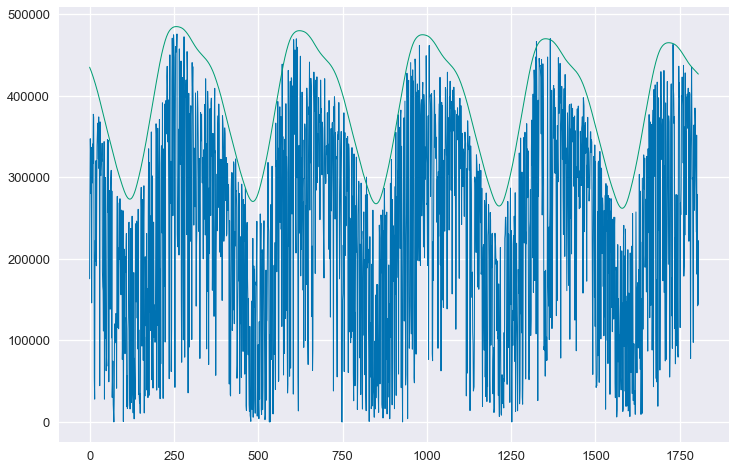

In [19]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]), linewidth=1)

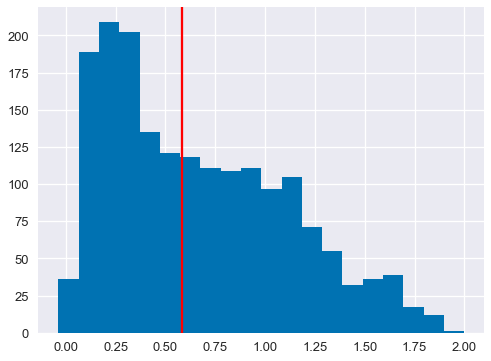

0.5805422480614114


In [20]:
residuals1 = (ics.R_cs.value[0] * np.sum(ics.L_cs.value[:, 0]) - np.sum(D, axis=0)) / np.average(np.sum(D, axis=0))
plt.figure(figsize=(8,6))
plt.hist(residuals1, bins=20)
plt.axvline(np.percentile(residuals1, 50), color='r')
plt.show()
print(np.percentile(residuals1, 50))

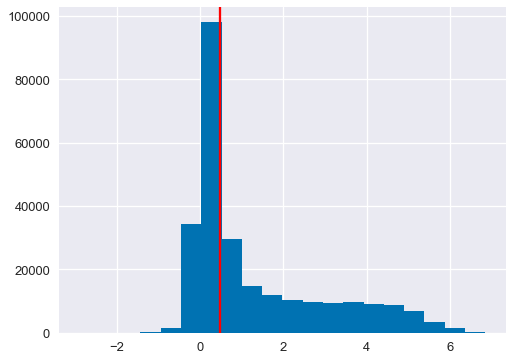

0.47543722748857165


In [21]:
residuals2 = ((ics.L_cs.value.dot(ics.R_cs.value) - ics.D) / np.average(ics.D))[ics.D > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(residuals2, bins=20)
plt.axvline(np.percentile(residuals2, 50), color='r')
plt.show()
print(np.percentile(residuals2, 50))

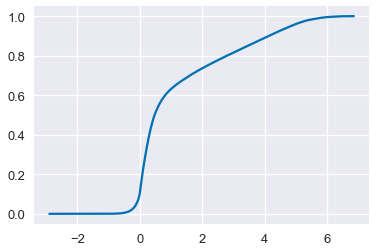

In [22]:
plt.plot(np.sort(residuals2), np.linspace(0, 1, len(residuals2), endpoint=False))

In [23]:
# Weight residuals by daily weight, which sets many days to zero. 
W1 = np.diag(ics.weights)
wres = np.dot(ics.L_cs.value.dot(ics.R_cs.value) - ics.D, W1)
use_days = np.logical_not(np.isclose(np.sum(wres, axis=0), 0))
scaled_wres = wres[:, use_days] / np.average(ics.D[:, use_days])
final_metric = scaled_wres[ics.D[:, use_days] > 1e-3]
plt.figure(figsize=(8,6))
plt.hist(, bins=20)
plt.axvline(np.percentile(final_metric, 50), color='r')
plt.show()
print(np.percentile(final_metric, 50), np.std(final_metric))

SyntaxError: invalid syntax (<ipython-input-23-0cdb332e86aa>, line 8)

In [ ]:
np.save('good_quantiles.npy', np.percentile(residuals2, np.arange(2, 99, 2)))

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = ics.L_cs.value.dot(ics.R_cs.value) - ics.D
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(r, cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(8,8), sharex=True)
    r = ics.L_cs.value.dot(ics.R_cs.value) - ics.D
    val = np.max([np.abs(np.min(r)), np.abs(np.max(r))])
    foo = ax.imshow(lowpass_2d(r, r=15), cmap='RdBu', interpolation='none', aspect='auto', vmin=-val, vmax=val)
    #plt.colorbar(label='kW')
    ax.set_title('Residual power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')
    plt.tight_layout()

In [ ]:
a = np.fft.fft2(r)[0]
plt.plot(np.abs(np.fft.fftshift(a)))

In [ ]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(lowpass_2d(D, r=15), cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.sum(D, axis=0), linewidth=1)
plt.plot(np.sum(lowpass_2d(D, r=15), axis=0), linewidth=3)